# Circuit Entanglement Matrix

This block calculate the entanglement matrix and the highest values qubit pairs to design the coupling map of given a circuit (or many circuits).

In [2]:
import numpy as np
from qiskit import QuantumCircuit,Aer, transpile, assemble
import matplotlib.pyplot as plt
from py_functions.layerlization import layerlization

In [3]:
class Coupling_Circuit:
    """
        This class has all the functionalities to:
        given a quantum circuit decompose the circuit into
        a set of subcircuits by depth. with max depth 2,3,4..
        N/2. N the number of total of quantum gates.
    """

    def __init__(self, qc, shots):
        self.qc = qc
        self.shots = shots

    #### Begin -- Supporting Functions ####
    """
        This functions are for working with the dictionaries of
        qiskit results.
    """
    def string2dict(q, len):
        st = ''
        for i in range(0,q+1):
            if i == 0:
                st += '1'
            else:
                st += '0'
        for i in range(0,len-q):
            st = '0'+st
        return st

    def string2dict_two(q1 ,q2, len):
        st = ''
        for i in range(0, len):
            if i == q1 or i == q2:
                st = '1' + st
            else:
                st = '0' + st
        return st

    def string2dict_zero(len):
        st = ''
        for i in range(0, len):
            st = '0' + st
        return st
    #### Finish -- Supporting Functions ####
    
    def general_entanglement(qc, 
                             qubit_m1, 
                             qubit_m2, 
                             shots : int == 1024):
        """
            Calculate the entanglement of a given pair of qubits.
            Using the concurrence the circuit is simulate with a
            perfect coupling.
            Input:
                qc: Quantum circuit.
                qubit_m1: first qubit to measure.
                qubit_m2: second qubit to measure.
                shots: number of shots.
            Output:
                Concurrence.
        """

        ent = 0
        qc_aux = qc.copy()

        qc_aux.measure([qubit_m1,qubit_m2],[qubit_m1,qubit_m2])
        Simulation = Aer.get_backend('qasm_simulator')
        Quantum_Transpiler = transpile(qc_aux,Simulation)
        Quantum_Obj = assemble(Quantum_Transpiler, shots=shots)
        Result = Simulation.run(Quantum_Obj).result()

        values_dict = Result.get_counts()

        value_00 = Coupling_Circuit.string2dict_zero(qc_aux.num_qubits)
        value_01 = Coupling_Circuit.string2dict(qubit_m1, 
                                                qc_aux.num_qubits-1)
        value_10 = Coupling_Circuit.string2dict(qubit_m2, 
                                                qc_aux.num_qubits-1)
        value_11 = Coupling_Circuit.string2dict_two(qubit_m1, 
                                                    qubit_m2, 
                                                    qc_aux.num_qubits)

        values_dict.setdefault(value_00, 0)
        values_dict.setdefault(value_01, 0)
        values_dict.setdefault(value_10, 0)
        values_dict.setdefault(value_11, 0)

        v_00 = np.sqrt(values_dict[value_00]/shots)
        v_01 = np.sqrt(values_dict[value_01]/shots)
        v_10 = np.sqrt(values_dict[value_10]/shots)
        v_11 = np.sqrt(values_dict[value_11]/shots)

        ent = 2*np.abs(v_11*v_00-v_01*v_10)

        return ent
    
    def ent_matrix(qc, shots):
        """
            This funciton calculates the entanglement
            matrix of a given circuit.
            Input:
                qc: quantum circuit.
                shots: number of shots.
            Output:
                new_matrix: entanglement matrix.
        """
        matrix = []

        for i in range(0, qc.num_qubits):
            for j in range(0, qc.num_qubits):
                if i == j:
                    matrix.append(0)
                else:
                    matrix.append(Coupling_Circuit.general_entanglement(qc,
                                                                        i,
                                                                        j, 
                                                                        shots))

        new_matrix = np.reshape(matrix, (qc.num_qubits, qc.num_qubits))

        return new_matrix
    
    def plot_ent_matrix(matrix : list):
        """
            Plot the matrix and export the png of the entanglement
            matrix.
            Input:
                matrix : list.
            Output:
                export png file.
        """

        fig, ax = plt.subplots()
        im = ax.imshow(matrix)
        ax.set_title("Entanglement Matrix Representation")
        ax.set_xlabel("Qubit")
        ax.set_ylabel("Qubit")
        fig.colorbar(im)
        for (j,i),label in np.ndenumerate(matrix):
            plt.text(i,j,"%.2f" % label,ha='center',va='center')
        
        fig.savefig("ent_matrix")

    def circuit_ent_matrices(subcircuits : list, shots : int == 1024):
        """
            This function calculate the entanglement over all the 
            subcircuits.
            Input:
                subcircuits :  list of quantum circuits.
                shots :  shots for the quantum circuit.
            Output:
                total_matrix: entanglement matrix of a given
                subcircuit.
        """
        total_matrix = 0
        len_subcircuits = len(subcircuits)
        for i in subcircuits:
            total_matrix += Coupling_Circuit.ent_matrix(i, 
                                                        shots)
        total_matrix = total_matrix/len_subcircuits

        return total_matrix

    def ent_matrix_final(qc, shots):
        """
            !!!Main function!!!
            This function calls leyerization to create all the
            subcircuit and calculate the entanglement matrix of
            each of them. After that, create the total matrix.
            That takes into account the entanglement of all the
            subcircuits.
            Input:
                qc: quantum circuit.
                shots: shots for the quantum circuit.
            Output:
                total_matrix: matrix that takes into the account
                all the ent matrix of each subcircuit.

        """
        total_matrix = 0
        max_value = int(len(qc.data)/2+1)
        for i in range(2,max_value):
            subcircuits = layerlization(qc, i)
            total_matrix = total_matrix + \
                        Coupling_Circuit.circuit_ent_matrices(subcircuits, shots)

        total_matrix = total_matrix/(max_value-2)

        return total_matrix

# Example

Let's create a quantum circuit and extract the most important qubits based on the entanglement between the sub circuits.

### Quantum Circuit 1:

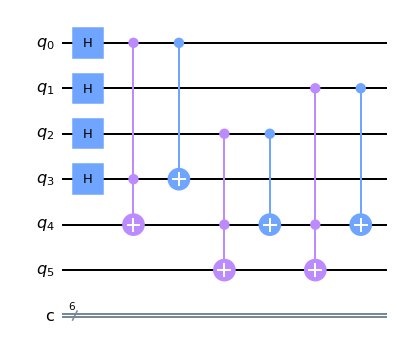

In [11]:
qc = QuantumCircuit(6,6)
qc.h([0,1,2,3])
qc.ccx(0,3,4)
qc.cx(0,3)
qc.ccx(2,4,5)
qc.cx(2,4)
qc.ccx(1,4,5)
qc.cx(1,4)
qc.draw('mpl')

In [12]:
## Calculate the entanglement matrix: (As simple as just one line)
matrix = Coupling_Circuit.ent_matrix_final(qc, 1024)

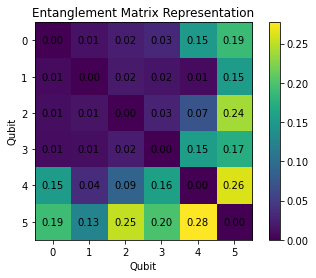

In [13]:
## Plot and export the matrix!
Coupling_Circuit.plot_ent_matrix(matrix)

As you can see from the image above. The most important qubits (in terms of connections) are the connection between the qubit 5 and 2; and 5 and 4.  
In other terms, the coupling map must be prioritize the coupling [5,2] and [5,4].


# Example

In [9]:
def top_cinco_valores(matriz):
    # Aplanar la matriz y almacenar el valor con su posición
    valores_con_posiciones = [(valor, (i, j)) for i, fila in enumerate(matriz) for j, valor in enumerate(fila)]

    # Ordenar los valores (de mayor a menor)
    valores_con_posiciones.sort(key=lambda x: x[0], reverse=True)

    # Seleccionar los primeros cinco elementos
    primeros_cinco = valores_con_posiciones[:5]

    # Extraer solo las posiciones de estos elementos
    posiciones_primeros_cinco = [pos for _, pos in primeros_cinco]

    return posiciones_primeros_cinco

In [10]:
top_cinco_valores(matrix)

[(5, 2), (4, 5), (2, 5), (5, 4), (5, 0)]